In [1]:
import time

from discretize import TreeMesh, TensorMesh
from discretize.utils import refine_tree_xyz, active_from_xyz

from SimPEG.utils import mkvc, model_builder
from SimPEG import maps
import SimPEG.electromagnetics.time_domain as tdem

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import constants

%matplotlib widget

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

In [2]:
def peak_time(depth, conductivity, mu=constants.mu_0):
    """
    Compute peak time following TDEM diffussion formula
    """
    return 1 / 6 * mu * conductivity * depth**2

def peak_depth(time, conductivity, mu=constants.mu_0):
    """
    Compute peak depth following TDEM diffussion formula
    """
    return np.sqrt(2 * time / mu / conductivity)

Define survey

1 Trasmiter and 11 resivers

In [29]:
# Defining transmitter locations = (0,0,0)
x, y, z = 0, 0, 0
source_location = np.array([x, y, z])
source_radius = 10  # source loop radius
source_orientation = "z" 
source_current = 1.0  # maximum on-time current


# Define the source waveform. Define a unit step-off.
off_time = 1e-5
waveform = tdem.sources.StepOffWaveform(off_time)

# Observation times for response (time channels)
time_channels = np.logspace(-5, 1, 31)

# Define receiver list. They location is along the x-axis 
receiver_list = []
receiver_orientation = "z"  # "x", "y" or "z"
for xp in np.linspace(-30, 30, 11):
    receiver_list.append(
    tdem.receivers.PointMagneticField(
        np.array([xp, 0, 0]), time_channels, orientation=receiver_orientation
    )
)

# Define source list
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)

Design mesh and simulation

In [30]:
# Conductivity in S/m (or resistivity in Ohm m)
air_conductivity = 1e-8
background_conductivity = 1e-1


In [31]:
min_simulation_time = off_time
max_simulation_time = 1e-0

Compute minimum and maximum diffusion distances

In [32]:
min_diffusion_distance = min(
    peak_depth(min_simulation_time, background_conductivity),
    peak_depth(min_simulation_time, air_conductivity),
) 

max_diffusion_distance = min(  # if I use the maximum I get crazy large values, I'll go with the min then
    peak_depth(max_simulation_time, background_conductivity),
    peak_depth(max_simulation_time, air_conductivity),
)

min_diffusion_distance, max_diffusion_distance

(12.615662606666971, 3989.4228029284545)

In [33]:
# Estimate smallest cell size as 10% of the smallest diffusion distance

smallest_cell_size = 0.1 * min_diffusion_distance
smallest_cell_size

1.2615662606666973

In [34]:
cell_size = 2    # minimum cell size
n_cells_xz = 2**6
n_cells_y = 2**6

hxz = cell_size * np.ones(n_cells_xz)
hy = cell_size * np.ones(n_cells_y)

mesh = TreeMesh([hxz, hy, hxz],x0="CCC")

# Refine to largest possible cell size
mesh.refine(3, finalize=False)


# Define topography and refine 
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = 0 * np.ones_like(xx)
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Refine mesh
mesh.refine_surface(topo, -1, 
                    padding_cells_by_level=3, 
                    #pad_up=3, 
                    #pad_down=5
                   )
mesh.finalize()

# Set active cells and define unit values
ind_active = active_from_xyz(mesh, topo)
model_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

# Define model for cells under the surface topography
model = background_conductivity * np.ones(ind_active.sum())

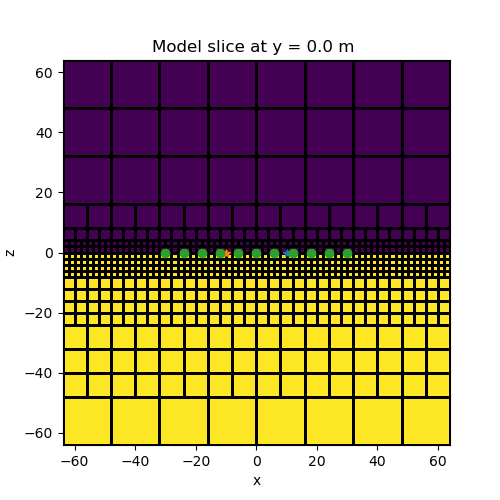

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))
ind_slice = int(mesh.h[1].size / 2)
mesh.plot_slice(model_map * model, normal='y', ax=ax, grid=True, ind=ind_slice)
ax.set_title(f"Model slice at y = {mesh.x0[1] + np.sum(mesh.h[1][0:ind_slice])} m ")
plt.plot(source_radius, 0, '*')
plt.plot(-source_radius, 0, '*')
plt.plot(np.linspace(-30, 30, 11), 0* np.ones_like(np.linspace(-30, 30, 11)), 'o')
plt.show()

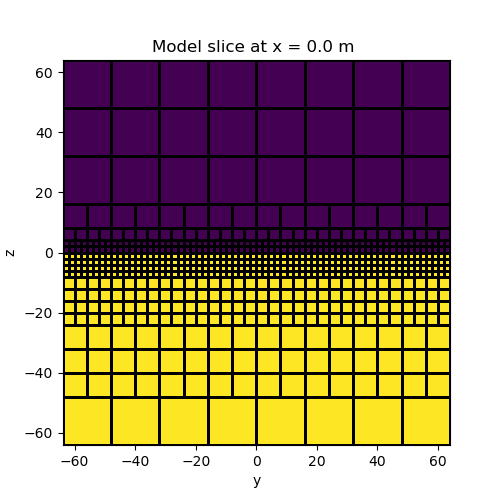

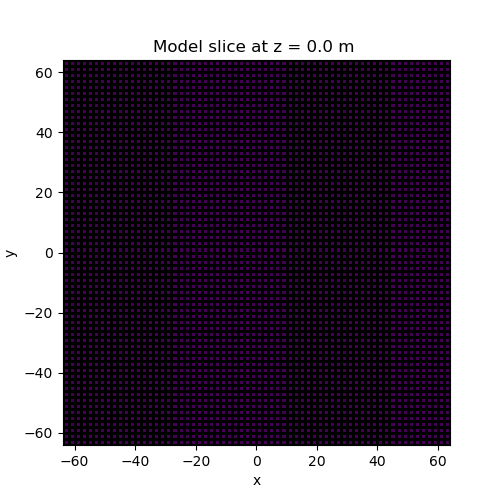

In [36]:
# Plot

for ni, axi in enumerate(['x', 'z']):
    fig, ax = plt.subplots(figsize=(5, 5))
    ind_slice = int(mesh.h[ni].size / 2)
    mesh.plot_slice(model_map * model, normal=axi, ax=ax, grid=True, 
                    ind=ind_slice
                   )
    ax.set_title(f"Model slice at {axi} = {mesh.x0[ni] + np.sum(mesh.h[ni][0:ind_slice])} m ")
    plt.show()



In [37]:
mesh

OcTreeMesh: 11.82% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       256            ---------------------------   --------------------
  4   :      1024         x:     -64.0    ,    64.0           2.0    ,    16.0   
  5   :      5120         y:     -64.0    ,    64.0           2.0    ,    16.0   
  6   :      24576        z:     -64.0    ,    64.0           2.0    ,    16.0   
-----------------------
Total :      30976

Simulation:

In [38]:
time_steps = [
             #1e-5,
            (1e-5, 10),
            (5e-5, 10),
            (1e-4, 10),
            (1e-3, 10),
            (5e-3, 10),
            (5e-2, 10),
            (1e-2, 10),
            (1e-1, 10),
            (1e-0, 10),
             ]

simulation = tdem.simulation.Simulation3DMagneticField(
    mesh, survey=survey, sigmaMap=model_map, solver=Solver
)

# Set the time-stepping for the simulation
simulation.time_steps = time_steps


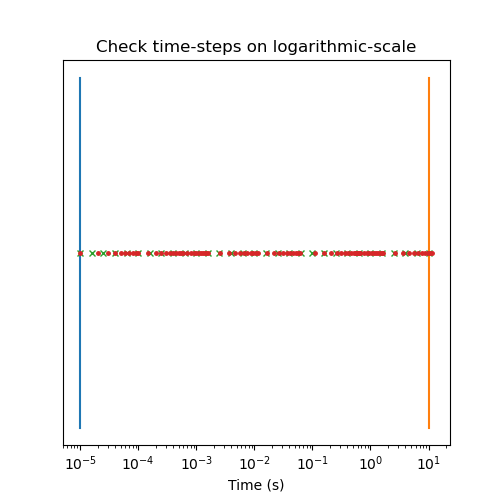

Min/max times    : 1.0e-05 / 1.0e+01
Min/max timeSteps: 1.0e-05 / 1.2e+01


In [39]:
# Logarithmic scale
# Create mesh with time steps
ts = TensorMesh([time_steps]).nodes_x


fig, ax = plt.subplots(figsize=(5, 5))
plt.title("Check time-steps on logarithmic-scale")
plt.plot([time_channels.min(), time_channels.min()], [-1, 1])
plt.plot([time_channels.max(), time_channels.max()], [-1, 1])
plt.plot(time_channels, time_channels*0, "x", ms=5)

plt.plot(ts, ts * 0, ".", ms=5)
#plt.plot(off_time, off_time * 0, "*", ms=5)
plt.yticks([])
plt.xscale("log")
plt.xlabel("Time (s)")
plt.show()

# Check times with time-steps
print(f"Min/max times    : {time_channels.min():.1e} / {time_channels.max():.1e}")
print(f"Min/max timeSteps: {ts[1]:.1e} / {ts[-1]:.1e}")

In [40]:
# Data are organized by transmitter, then by receiver then by observation time.
start = time.time()
dpred = simulation.dpred(model)
end = time.time()

print(f"Elapsed time: {end - start:.2f}s")


Elapsed time: 17.81s


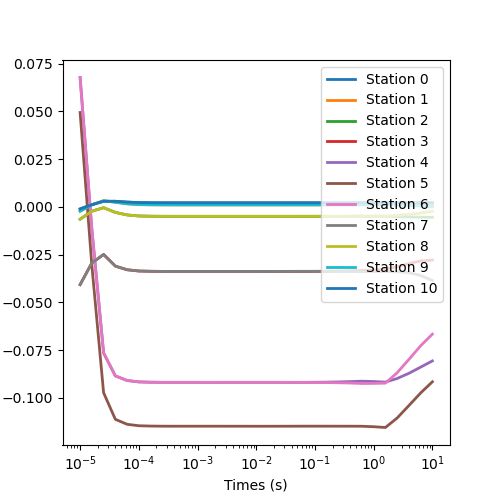

In [54]:
# Plot sounding
fig, ax = plt.subplots(figsize=(5, 5))

for i, d in enumerate(dpred.reshape((11, 31))):
    ax.plot(time_channels, d, lw=2, label=f'Station {i}')

ax.set_xscale('log')
ax.set_xlabel("Times (s)")
ax.set_ylabel("Hz [A/m]")

plt.legend()
plt.show()

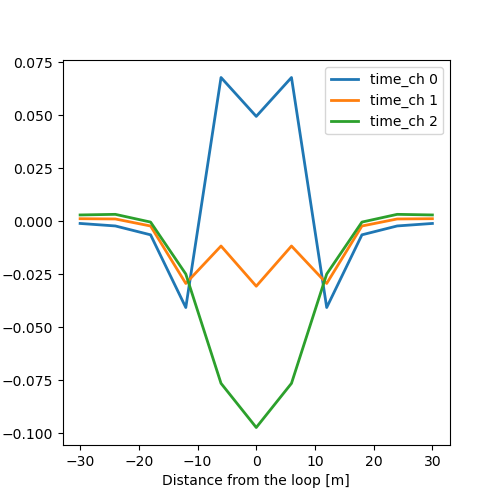

In [52]:
# Plot sounding
fig, ax = plt.subplots(figsize=(5, 5))

for i, data in enumerate(dpred.reshape((11,31)).T[:3]):
    ax.plot(np.linspace(-30, 30, 11), data,  lw=2, label=f'time_ch {i}')

#ax.set_xscale('log')
ax.set_xlabel("Distance from the loop")
ax.set_xlabel("Distance from the loop [m]")
ax.set_ylabel("Hz [A/m]")
plt.legend()
plt.show()

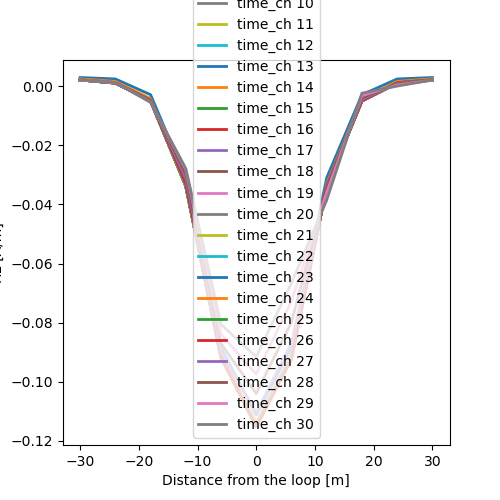

In [53]:
# Plot sounding
fig, ax = plt.subplots(figsize=(5, 5))

for i, data in enumerate(dpred.reshape((11,31)).T[3:]):
    ax.plot(np.linspace(-30, 30, 11), data,  lw=2, label=f'time_ch {i+3}')

#ax.set_xscale('log')
ax.set_xlabel("Distance from the loop [m]")
ax.set_ylabel("Hz [A/m]")
plt.legend()
plt.show()

In [46]:
constants.mu_0*source_current/(2*source_radius)

6.283185310599999e-08

In [47]:
source_current/(2*source_radius)

0.05

In [49]:
dpred.reshape((11,31)).T[0].max()

0.0677701802701928

In [50]:
1 /( dpred.reshape((11,31)).T[0].max() * 2 / source_current)

7.377876198743326

In [51]:
1/(dpred.reshape((11,31)).T[0].max() * 2 / (constants.mu_0 * source_current))

9.271312671073885e-06